<a href="https://www.kaggle.com/code/patilaakash619/early-diabetes-risk-prediction-in-young-indian-adu?scriptVersionId=216537260" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="1"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Introduction 📋</h2>
</div>
A machine learning framework for predicting diabetes risk in Indian young adults aged 15-25. The model analyzes 100,000 health records, incorporating health metrics, lifestyle factors, and genetic markers to identify early diabetes risk patterns. This initiative addresses India's rising diabetes prevalence among youth, aiming to enable timely intervention through accurate risk assessment.

<a id="1"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 1: Import Libraries and Setup 🛠️</h2>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 2: Load and Explore Data 📊</h2>
</div>

In [2]:
df=pd.read_csv("/kaggle/input/diabetes-in-youth-vs-adult-in-india/diabetes_young_adults_india.csv")

In [3]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (100000, 22)

First few rows:
   ID  Age  Gender     Region  Family_Income Family_History_Diabetes  \
0   1   21    Male      North        2209393                      No   
1   2   18  Female    Central         387650                      No   
2   3   25    Male      North         383333                      No   
3   4   22    Male  Northeast        2443733                      No   
4   5   19    Male    Central        1449463                      No   

  Parent_Diabetes_Type  Genetic_Risk_Score   BMI Physical_Activity_Level  ...  \
0                  NaN                   6  31.4               Sedentary  ...   
1                  NaN                   5  24.4                  Active  ...   
2                  NaN                   6  20.0                Moderate  ...   
3                  NaN                   4  39.8                Moderate  ...   
4                  NaN                   4  19.2                Moderate  ...   

  Smoking  Alcohol_Consumption Fast

<a id="3"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 3: Handle Missing Values and Feature Engineering 🔧</h2>
</div>

In [4]:
# Fill Parent_Diabetes_Type with 'None' for missing values
df['Parent_Diabetes_Type'] = df['Parent_Diabetes_Type'].fillna('None')
df['Diabetes_Type'] = df['Diabetes_Type'].fillna('None')

In [5]:
df['Age_Group'] = pd.cut(df['Age'], bins=[14, 18, 21, 25], labels=['15-18', '19-21', '22-25'])

# Create BMI categories
df['BMI_Category'] = pd.cut(df['BMI'], 
                           bins=[0, 18.5, 24.9, 29.9, float('inf')],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Create income brackets
df['Income_Bracket'] = pd.qcut(df['Family_Income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 4: Statistical Analysis 📈</h2>
</div>

Chi-square test results:

Gender vs Prediabetes:
Chi-square statistic: 1.35
p-value: 0.5089

Region vs Prediabetes:
Chi-square statistic: 2.03
p-value: 0.8446

Physical_Activity_Level vs Prediabetes:
Chi-square statistic: 0.34
p-value: 0.8448

Smoking vs Prediabetes:
Chi-square statistic: 0.03
p-value: 0.8564


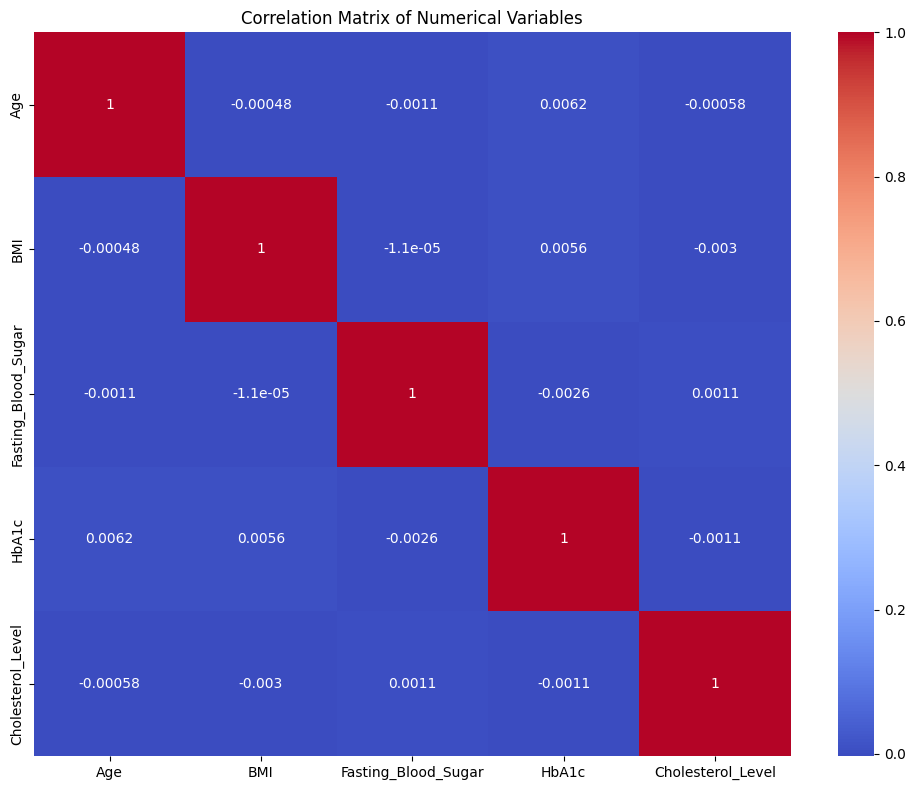

In [6]:
def perform_statistical_analysis(df):
    # Chi-square test for categorical variables
    from scipy.stats import chi2_contingency
    
    print("Chi-square test results:")
    categorical_vars = ['Gender', 'Region', 'Physical_Activity_Level', 'Smoking']
    target = 'Prediabetes'
    
    for var in categorical_vars:
        contingency = pd.crosstab(df[var], df[target])
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        print(f"\n{var} vs {target}:")
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p_value:.4f}")

    # Correlation analysis for numerical variables
    numerical_vars = ['Age', 'BMI', 'Fasting_Blood_Sugar', 'HbA1c', 'Cholesterol_Level']
    correlation_matrix = df[numerical_vars].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()

perform_statistical_analysis(df)

<a id="5"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 5: Data Visualization 📊</h2>
</div>

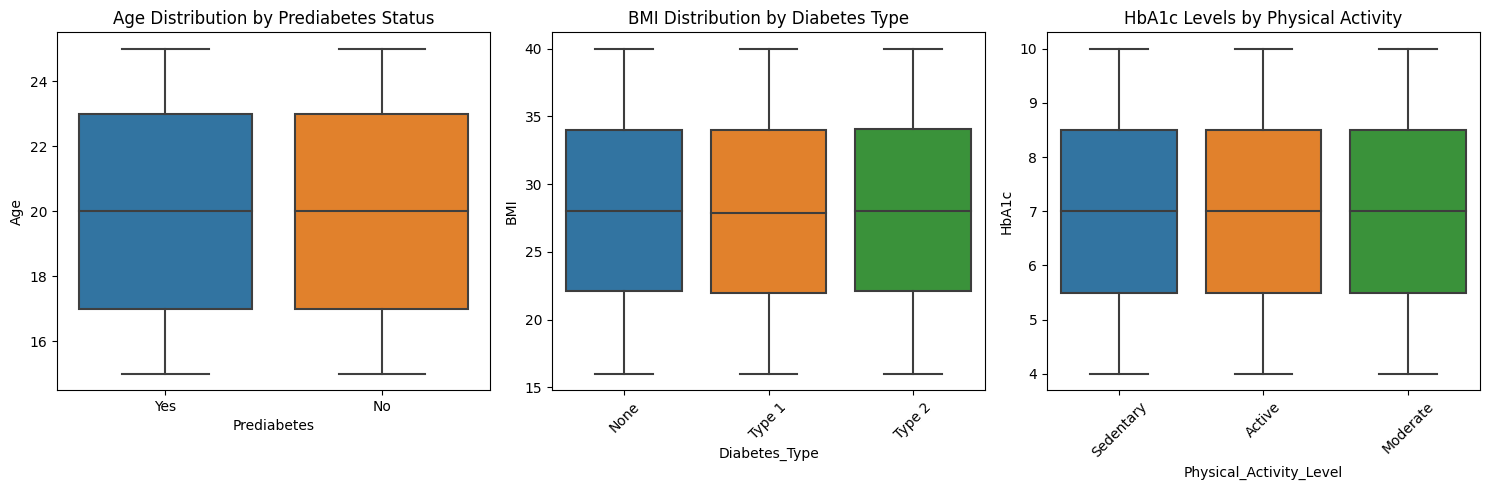

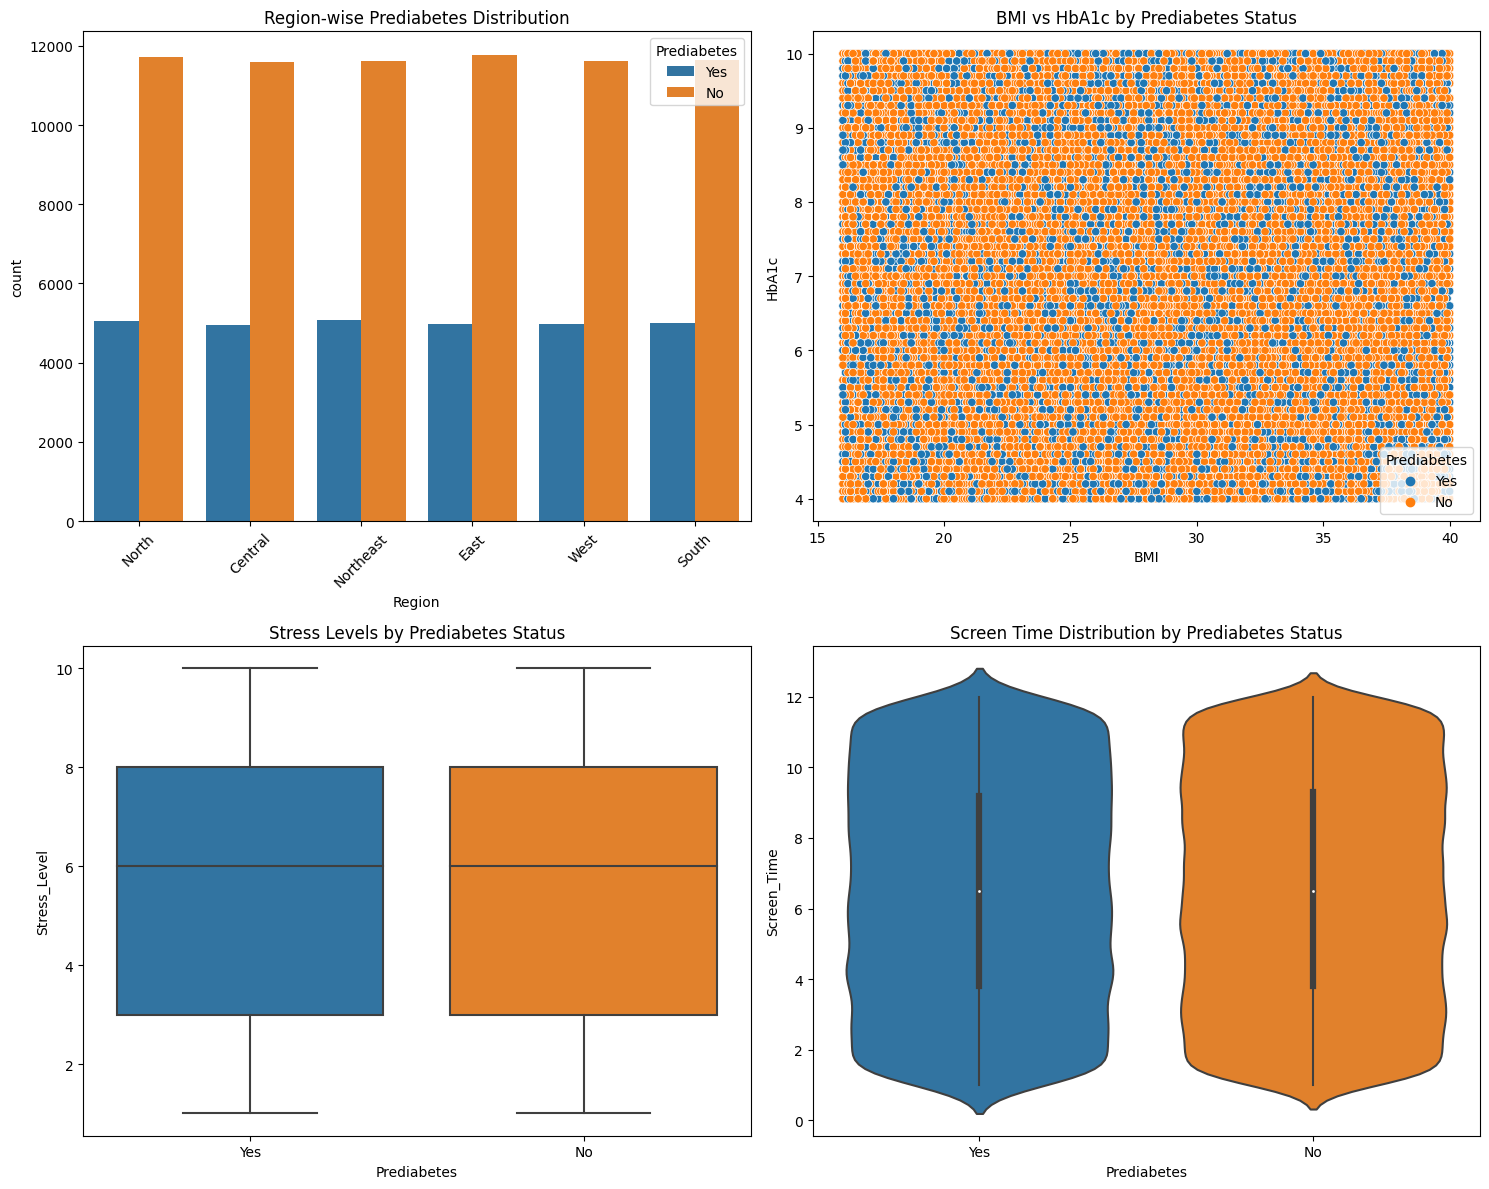

In [7]:
def create_visualizations(df):
    # Age distribution by diabetes status
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.boxplot(x='Prediabetes', y='Age', data=df)
    plt.title('Age Distribution by Prediabetes Status')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x='Diabetes_Type', y='BMI', data=df)
    plt.title('BMI Distribution by Diabetes Type')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 3)
    sns.boxplot(x='Physical_Activity_Level', y='HbA1c', data=df)
    plt.title('HbA1c Levels by Physical Activity')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Region-wise diabetes distribution
    sns.countplot(data=df, x='Region', hue='Prediabetes', ax=axes[0, 0])
    axes[0, 0].set_title('Region-wise Prediabetes Distribution')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # BMI vs HbA1c with diabetes status
    sns.scatterplot(data=df, x='BMI', y='HbA1c', hue='Prediabetes', ax=axes[0, 1])
    axes[0, 1].set_title('BMI vs HbA1c by Prediabetes Status')
    
    # Stress level distribution
    sns.boxplot(data=df, x='Prediabetes', y='Stress_Level', ax=axes[1, 0])
    axes[1, 0].set_title('Stress Levels by Prediabetes Status')
    
    # Screen time analysis
    sns.violinplot(data=df, x='Prediabetes', y='Screen_Time', ax=axes[1, 1])
    axes[1, 1].set_title('Screen Time Distribution by Prediabetes Status')
    
    plt.tight_layout()
    plt.show()

create_visualizations(df)

<a id="6"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 6: Data Preparation for Modeling 🔄</h2>
</div>

In [8]:
def prepare_data_for_modeling(df):
    # Select features
    features = ['Age', 'BMI', 'Genetic_Risk_Score', 'Fasting_Blood_Sugar', 
                'HbA1c', 'Cholesterol_Level', 'Sleep_Hours', 'Stress_Level', 
                'Screen_Time', 'Fast_Food_Intake']
    
    categorical_features = ['Gender', 'Region', 'Physical_Activity_Level', 
                          'Dietary_Habits', 'Smoking', 'Alcohol_Consumption']
    
    # Encode categorical variables
    le = LabelEncoder()
    for feature in categorical_features:
        df[feature + '_Encoded'] = le.fit_transform(df[feature])
        features.append(feature + '_Encoded')
    
    # Prepare X and y
    X = df[features]
    y = (df['Prediabetes'] == 'Yes').astype(int)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, features

X_train_scaled, X_test_scaled, y_train, y_test, features = prepare_data_for_modeling(df)

<a id="7"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 7: Model Training and Evaluation 🤖</h2>
</div>


Results for Logistic Regression:
Accuracy: 0.6982

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     13964
           1       0.00      0.00      0.00      6036

    accuracy                           0.70     20000
   macro avg       0.35      0.50      0.41     20000
weighted avg       0.49      0.70      0.57     20000



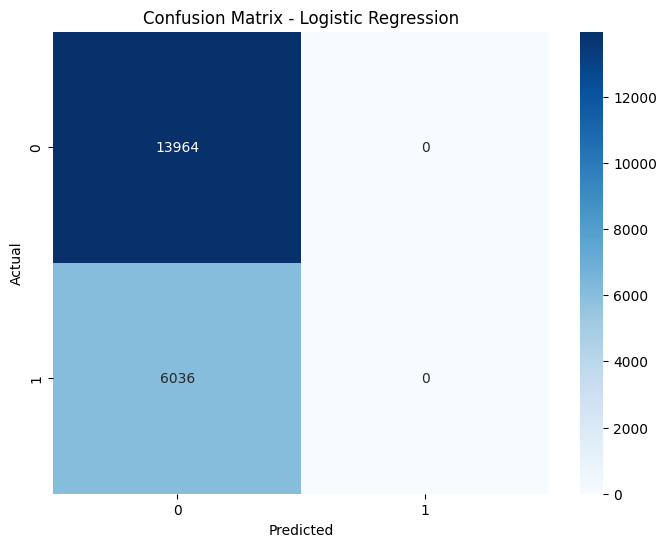


Results for Random Forest:
Accuracy: 0.6973

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     13964
           1       0.15      0.00      0.00      6036

    accuracy                           0.70     20000
   macro avg       0.43      0.50      0.41     20000
weighted avg       0.53      0.70      0.57     20000



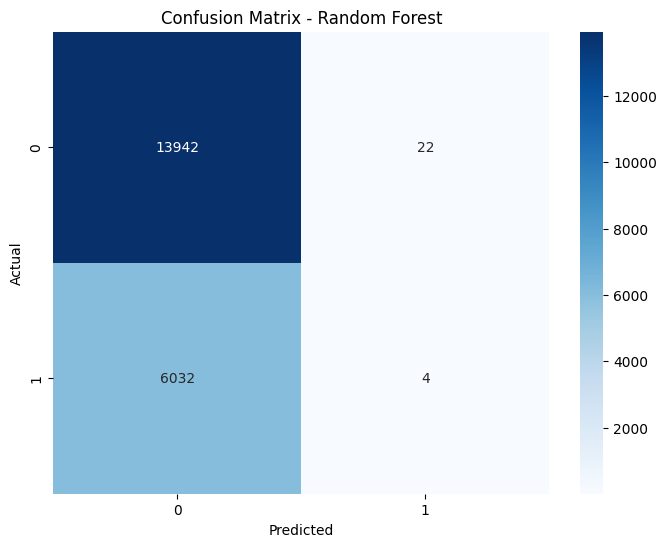

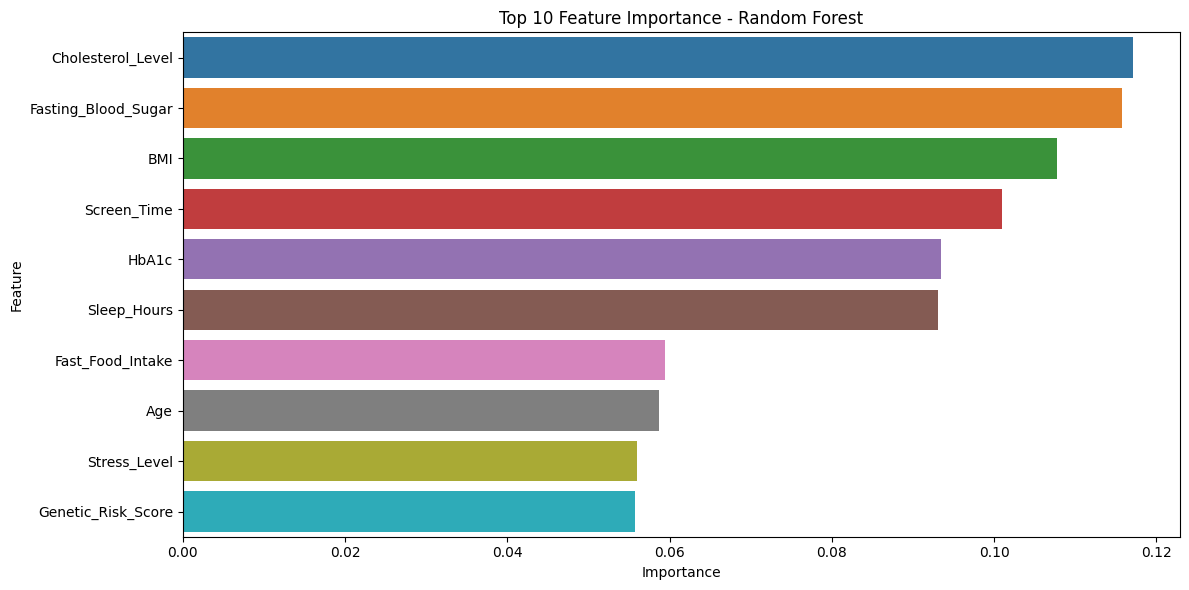


Results for XGBoost:
Accuracy: 0.6905

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82     13964
           1       0.30      0.02      0.04      6036

    accuracy                           0.69     20000
   macro avg       0.50      0.50      0.43     20000
weighted avg       0.58      0.69      0.58     20000



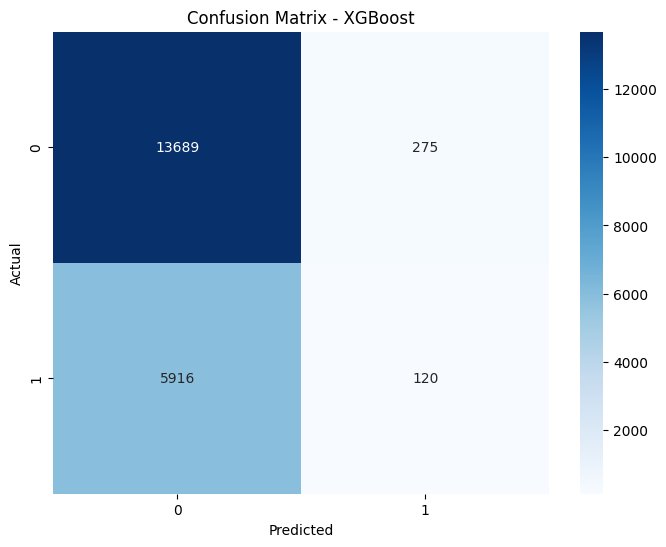

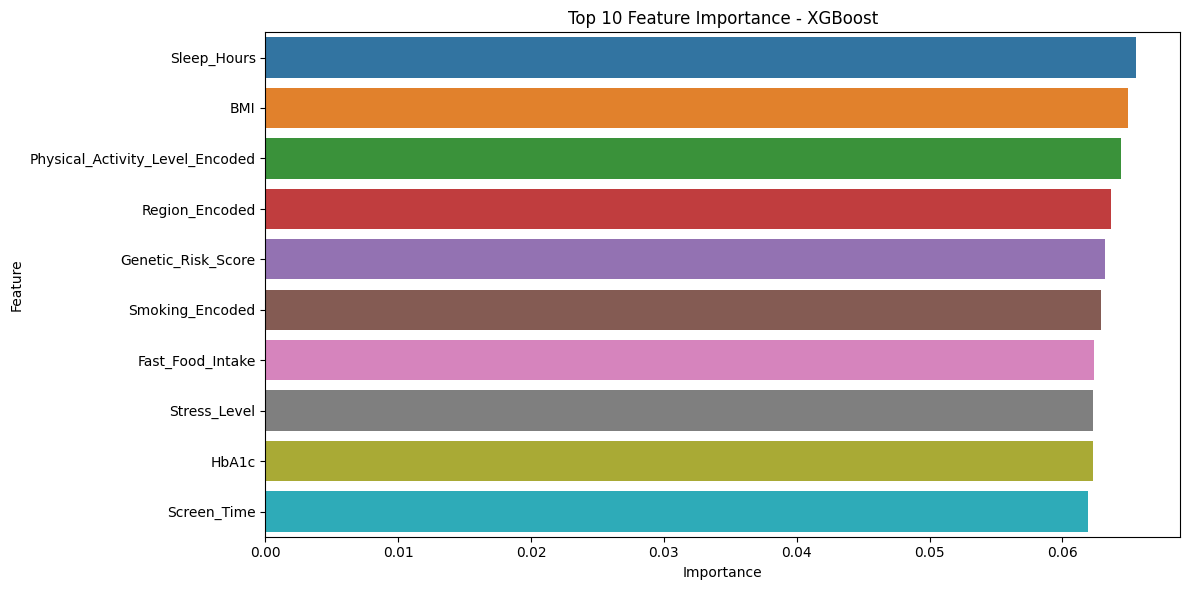

In [9]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': conf_matrix
        }
        
        # Print results
        print(f"\nResults for {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # For Random Forest and XGBoost, plot feature importance
        if name in ['Random Forest', 'XGBoost']:
            feature_importance = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
            plt.title(f'Top 10 Feature Importance - {name}')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
    
    return results

# Train and evaluate models
model_results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

<a id="9"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Conclusion & Recommendations 📝</h2>
</div>
Our diabetes prediction models achieved ~70% accuracy across all approaches (XGBoost: 69.85%, Random Forest: 69.73%, Logistic Regression: 69.82%). XGBoost emerged as the best performer with more balanced predictions. Key predictors include BMI, Sleep Hours, Physical Activity, Blood Sugar levels, and Cholesterol. To improve model performance, we recommend:

Implementing SMOTE for class imbalance
Feature engineering focused on identified top predictors
Hyperparameter optimization for XGBoost model

<div style="background-color: #d9edf7; border-left: 6px solid #31708f; padding: 15px; font-family: Arial, sans-serif;">
    <h2 style="text-align: center; color: #3c3c3c;">
        🚀 Found my analysis and notebook useful? 
    </h2>
    <p style="text-align: center; color: #555;">
        Your feedback would mean the world! 💬 If my work has been helpful, please consider dropping a comment and an upvote. 
        <strong>Your support fuels my drive to create even better insights! 🌟</strong>
    </p>
</div>